# W207 Final Project
## Jacky Wong, Renjun Cheng

### This code run on python 3.8.3 and tensorflow 2.3.1

#### Install and import following package before runing the code

In [287]:
# !pip3 install tensorflow pandas numpy matplotlib yahoo_fin sklearn requests_html

In [288]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import os
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from yahoo_fin import stock_info as si
from collections import deque

## Data Download and Processing

In [289]:
if not os.path.isdir("results"):
    os.mkdir("results")
if not os.path.isdir("logs"):
    os.mkdir("logs")
if not os.path.isdir("data"):
    os.mkdir("data")

In [290]:
def load_data(ticker, n_steps=50, scale=True, shuffle=True, lookup_step=1, 
                test_size=0.2, feature_columns=['adjclose', 'volume', 'open', 'high', 'low']):

    # see if ticker is already a loaded stock from yahoo finance
    if isinstance(ticker, str):
        df = si.get_data(ticker)
    elif isinstance(ticker, pd.DataFrame):
        df = ticker
    else:
        raise TypeError("ticker can be either a str or a `pd.DataFrame` instances")
        
        
    # this will contain all the elements we want to return from this function
    result = {}
    result['df'] = df.copy()

    
    for col in feature_columns:
        assert col in df.columns, f"'{col}' does not exist in the dataframe."
        
    if scale:
        column_scaler = {}
        # scale the data (prices) from 0 to 1
        for column in feature_columns:
            scaler = preprocessing.MinMaxScaler()
            df[column] = scaler.fit_transform(np.expand_dims(df[column].values, axis=1))
            column_scaler[column] = scaler
        result["column_scaler"] = column_scaler
    df['future'] = df['adjclose'].shift(-lookup_step)
    # last `lookup_step` columns contains NaN in future column
    # get them before droping NaNs
    
    
    last_sequence = np.array(df[feature_columns].tail(lookup_step))
    # drop NaNs
    df.dropna(inplace=True)
    sequence_data = []
    sequences = deque(maxlen=n_steps)
    for entry, target in zip(df[feature_columns].values, df['future'].values):
        sequences.append(entry)
        if len(sequences) == n_steps:
            sequence_data.append([np.array(sequences), target])       
    last_sequence = list(sequences) + list(last_sequence)
    last_sequence = np.array(last_sequence)
    result['last_sequence'] = last_sequence
    X, y = [], []
    for seq, target in sequence_data:
        X.append(seq)
        y.append(target)
    X = np.array(X)
    y = np.array(y)
    X = X.reshape((X.shape[0], X.shape[2], X.shape[1]))
    result["X_train"], result["X_test"], result["y_train"], result["y_test"] = train_test_split(X, y, 
                                                                               test_size=test_size, shuffle=shuffle) 
    return result

## RNN Model with LSTM

In [291]:
def create_model(sequence_length, units=256, cell=LSTM, n_layers=2, dropout=0.3,
                loss="mean_absolute_error", optimizer="rmsprop", bidirectional=False):
    model = Sequential()
    for i in range(n_layers):
        if i == 0:
            
            # first layer
            model.add(cell(units, return_sequences=True, input_shape=(None, sequence_length)))
        elif i == n_layers - 1:
            
            # last layer
            model.add(cell(units, return_sequences=False))
        else:
            
            # hidden layers
            model.add(cell(units, return_sequences=True))
            
        # add dropout after each layer
        model.add(Dropout(dropout))
    model.add(Dense(1, activation="linear"))
    model.compile(loss=loss, metrics=["mean_absolute_error"], optimizer=optimizer)
    return model

## Prediction function

In [292]:
def predict(model, data):
    # retrieve the last sequence from data
    last_sequence = data["last_sequence"][-N_STEPS:]
    # retrieve the column scalers
    column_scaler = data["column_scaler"]
    # reshape the last sequence
    last_sequence = last_sequence.reshape((last_sequence.shape[1], last_sequence.shape[0]))
    # expand dimension
    last_sequence = np.expand_dims(last_sequence, axis=0)
    # get the prediction (scaled from 0 to 1)
    prediction = model.predict(last_sequence)
    # get the price (by inverting the scaling)
    predicted_price = column_scaler["adjclose"].inverse_transform(prediction)[0][0]
    return predicted_price

## Graph for predicted price vs real price

In [293]:
def plot_graph(model, data, time_period = 1000):
    y_test = data["y_test"]
    X_test = data["X_test"]
    y_pred = model.predict(X_test)
    y_test = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(np.expand_dims(y_test, axis=0)))
    y_pred = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(y_pred))
    plt.plot(y_test[-time_period:], c='b')
    plt.plot(y_pred[-time_period:], c='r')
    plt.xlabel("Days")
    plt.ylabel("Price")
    plt.legend(["Actual Price", "Predicted Price"])
    plt.show()

## Get Accuracy

In [294]:
def get_accuracy(model, data):
    y_test = data["y_test"]
    X_test = data["X_test"]
    y_pred = model.predict(X_test)
    y_test = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(np.expand_dims(y_test, axis=0)))
    y_pred = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(y_pred))
    y_pred = list(map(lambda current, future: int(float(future) > float(current)), y_test[:-LOOKUP_STEP], y_pred[LOOKUP_STEP:]))
    y_test = list(map(lambda current, future: int(float(future) > float(current)), y_test[:-LOOKUP_STEP], y_test[LOOKUP_STEP:]))
    return accuracy_score(y_test, y_pred)

## Backtest function to get return

In [295]:
def get_return(model, data):
    y_test = data["y_test"]
    X_test = data["X_test"]
    y_pred = model.predict(X_test)
    y_test = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(np.expand_dims(y_test, axis=0)))
    y_pred = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(y_pred))
    money = 1
    moneylist = []
    long_only = 1
    long_only_list = []
    for i in range(1,len(y_test)):
        if y_pred[i] >= y_pred[i-1]:
            long_short = 1
        else:
            long_short = -1
        money =  money * (1 + (y_test[i] - y_test[i-1])/y_test[i-1] * long_short) 
        long_only = long_only * (1 + (y_test[i] - y_test[i-1])/y_test[i-1] * 1) 
        moneylist.append(money)
        long_only_list.append(long_only)
    plt.plot(moneylist)
    plt.plot(long_only_list)
    return money,long_only

## Model 1: Nasdaq Index (QQQ) price prediction.

### All Parameters

In [296]:
### Which stock to predict
ticker = "QQQ"

# use numbers of previous days to predict
N_STEPS = 100

# which day to predict, 1 is for next day, 10 is for 10 days after today
LOOKUP_STEP = 1

### model parameters
N_LAYERS = 3
CELL = LSTM
UNITS = 256
DROPOUT = 0.5

### training parameters
LOSS = "huber_loss"
OPTIMIZER = "adam"
BATCH_SIZE = 50
EPOCHS = 500

### other parameters
TEST_SIZE = 0.2
FEATURE_COLUMNS = ["adjclose", "volume", "open", "high", "low"]
date_now = time.strftime("%Y-%m-%d")

### save data to csv locally
ticker_data_filename = os.path.join("data", f"{ticker}_{date_now}.csv")
model_name = f"{date_now}_{ticker}-{LOSS}-{OPTIMIZER}-{CELL.__name__}-seq-{N_STEPS}-step-{LOOKUP_STEP}-layers-{N_LAYERS}-units-{UNITS}"

In [297]:
# load the data
data = load_data(ticker, N_STEPS, lookup_step=LOOKUP_STEP, test_size=TEST_SIZE, feature_columns=FEATURE_COLUMNS)
data["df"].to_csv(ticker_data_filename)

# construct the model
model = create_model(N_STEPS, loss=LOSS, units=UNITS, cell=CELL, n_layers=N_LAYERS,
                    dropout=DROPOUT, optimizer=OPTIMIZER)

# some tensorflow callbacks
checkpointer = ModelCheckpoint(os.path.join("results", model_name + ".h5"), save_weights_only=True, save_best_only=True, verbose=1)
tensorboard = TensorBoard(log_dir=os.path.join("logs", model_name))
history = model.fit(data["X_train"], data["y_train"],
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(data["X_test"], data["y_test"]),
                    callbacks=[checkpointer, tensorboard],
                    verbose=1)
model.save(os.path.join("results", model_name) + ".h5")

Epoch 1/500
85/86 [============================>.] - ETA: 0s - loss: 0.0024 - mean_absolute_error: 0.0408
Epoch 00001: val_loss improved from inf to 0.00055, saving model to results/2020-12-10_QQQ-huber_loss-adam-LSTM-seq-100-step-1-layers-3-units-256.h5
86/86 [==============================] - 3s 39ms/step - loss: 0.0024 - mean_absolute_error: 0.0407 - val_loss: 5.5018e-04 - val_mean_absolute_error: 0.0202
Epoch 2/500
84/86 [============================>.] - ETA: 0s - loss: 0.0011 - mean_absolute_error: 0.0296
Epoch 00002: val_loss did not improve from 0.00055
86/86 [==============================] - 2s 24ms/step - loss: 0.0011 - mean_absolute_error: 0.0296 - val_loss: 7.8614e-04 - val_mean_absolute_error: 0.0292
Epoch 3/500
85/86 [============================>.] - ETA: 0s - loss: 9.3492e-04 - mean_absolute_error: 0.0278
Epoch 00003: val_loss improved from 0.00055 to 0.00031, saving model to results/2020-12-10_QQQ-huber_loss-adam-LSTM-seq-100-step-1-layers-3-units-256.h5
86/86 [======

Epoch 23/500
84/86 [============================>.] - ETA: 0s - loss: 4.3161e-04 - mean_absolute_error: 0.0191
Epoch 00023: val_loss did not improve from 0.00009
86/86 [==============================] - 2s 20ms/step - loss: 4.2929e-04 - mean_absolute_error: 0.0190 - val_loss: 1.8430e-04 - val_mean_absolute_error: 0.0134
Epoch 24/500
85/86 [============================>.] - ETA: 0s - loss: 3.4663e-04 - mean_absolute_error: 0.0164
Epoch 00024: val_loss did not improve from 0.00009
86/86 [==============================] - 2s 22ms/step - loss: 3.4843e-04 - mean_absolute_error: 0.0165 - val_loss: 1.7318e-04 - val_mean_absolute_error: 0.0116
Epoch 25/500
84/86 [============================>.] - ETA: 0s - loss: 3.4863e-04 - mean_absolute_error: 0.0169
Epoch 00025: val_loss did not improve from 0.00009
86/86 [==============================] - 2s 20ms/step - loss: 3.4824e-04 - mean_absolute_error: 0.0169 - val_loss: 1.5027e-04 - val_mean_absolute_error: 0.0118
Epoch 26/500
84/86 [==============

86/86 [==============================] - ETA: 0s - loss: 2.8942e-04 - mean_absolute_error: 0.0162
Epoch 00047: val_loss improved from 0.00005 to 0.00004, saving model to results/2020-12-10_QQQ-huber_loss-adam-LSTM-seq-100-step-1-layers-3-units-256.h5
86/86 [==============================] - 2s 21ms/step - loss: 2.8942e-04 - mean_absolute_error: 0.0162 - val_loss: 4.2897e-05 - val_mean_absolute_error: 0.0060
Epoch 48/500
85/86 [============================>.] - ETA: 0s - loss: 2.5634e-04 - mean_absolute_error: 0.0151
Epoch 00048: val_loss did not improve from 0.00004
86/86 [==============================] - 2s 20ms/step - loss: 2.5707e-04 - mean_absolute_error: 0.0151 - val_loss: 6.8176e-05 - val_mean_absolute_error: 0.0073
Epoch 49/500
83/86 [===========================>..] - ETA: 0s - loss: 3.0860e-04 - mean_absolute_error: 0.0165
Epoch 00049: val_loss did not improve from 0.00004
86/86 [==============================] - 2s 20ms/step - loss: 3.0676e-04 - mean_absolute_error: 0.0165 - 

85/86 [============================>.] - ETA: 0s - loss: 2.6894e-04 - mean_absolute_error: 0.0154
Epoch 00071: val_loss did not improve from 0.00004
86/86 [==============================] - 2s 20ms/step - loss: 2.6818e-04 - mean_absolute_error: 0.0154 - val_loss: 9.9365e-05 - val_mean_absolute_error: 0.0097
Epoch 72/500
85/86 [============================>.] - ETA: 0s - loss: 2.6965e-04 - mean_absolute_error: 0.0158
Epoch 00072: val_loss did not improve from 0.00004
86/86 [==============================] - 2s 19ms/step - loss: 2.6896e-04 - mean_absolute_error: 0.0158 - val_loss: 2.0076e-04 - val_mean_absolute_error: 0.0124
Epoch 73/500
86/86 [==============================] - ETA: 0s - loss: 2.3406e-04 - mean_absolute_error: 0.0148
Epoch 00073: val_loss did not improve from 0.00004
86/86 [==============================] - 2s 20ms/step - loss: 2.3406e-04 - mean_absolute_error: 0.0148 - val_loss: 1.2714e-04 - val_mean_absolute_error: 0.0134
Epoch 74/500
85/86 [===========================

85/86 [============================>.] - ETA: 0s - loss: 2.2954e-04 - mean_absolute_error: 0.0145
Epoch 00096: val_loss did not improve from 0.00004
86/86 [==============================] - 2s 26ms/step - loss: 2.2918e-04 - mean_absolute_error: 0.0145 - val_loss: 1.2287e-04 - val_mean_absolute_error: 0.0120
Epoch 97/500
86/86 [==============================] - ETA: 0s - loss: 2.6824e-04 - mean_absolute_error: 0.0157
Epoch 00097: val_loss did not improve from 0.00004
86/86 [==============================] - 2s 24ms/step - loss: 2.6824e-04 - mean_absolute_error: 0.0157 - val_loss: 5.1412e-05 - val_mean_absolute_error: 0.0074
Epoch 98/500
86/86 [==============================] - ETA: 0s - loss: 2.2033e-04 - mean_absolute_error: 0.0142
Epoch 00098: val_loss did not improve from 0.00004
86/86 [==============================] - 2s 22ms/step - loss: 2.2033e-04 - mean_absolute_error: 0.0142 - val_loss: 9.8957e-05 - val_mean_absolute_error: 0.0108
Epoch 99/500
84/86 [===========================

Epoch 121/500
85/86 [============================>.] - ETA: 0s - loss: 2.1559e-04 - mean_absolute_error: 0.0142
Epoch 00121: val_loss did not improve from 0.00003
86/86 [==============================] - 2s 21ms/step - loss: 2.1449e-04 - mean_absolute_error: 0.0142 - val_loss: 4.0602e-05 - val_mean_absolute_error: 0.0056
Epoch 122/500
85/86 [============================>.] - ETA: 0s - loss: 2.1238e-04 - mean_absolute_error: 0.0142
Epoch 00122: val_loss did not improve from 0.00003
86/86 [==============================] - 2s 20ms/step - loss: 2.1170e-04 - mean_absolute_error: 0.0142 - val_loss: 3.9611e-05 - val_mean_absolute_error: 0.0056
Epoch 123/500
86/86 [==============================] - ETA: 0s - loss: 2.5517e-04 - mean_absolute_error: 0.0154
Epoch 00123: val_loss did not improve from 0.00003
86/86 [==============================] - 2s 20ms/step - loss: 2.5517e-04 - mean_absolute_error: 0.0154 - val_loss: 5.8669e-05 - val_mean_absolute_error: 0.0073
Epoch 124/500
85/86 [==========

84/86 [============================>.] - ETA: 0s - loss: 2.0267e-04 - mean_absolute_error: 0.0138
Epoch 00146: val_loss did not improve from 0.00003
86/86 [==============================] - 2s 20ms/step - loss: 2.0281e-04 - mean_absolute_error: 0.0138 - val_loss: 3.6010e-05 - val_mean_absolute_error: 0.0060
Epoch 147/500
86/86 [==============================] - ETA: 0s - loss: 2.1762e-04 - mean_absolute_error: 0.0143
Epoch 00147: val_loss did not improve from 0.00003
86/86 [==============================] - 2s 20ms/step - loss: 2.1762e-04 - mean_absolute_error: 0.0143 - val_loss: 3.6793e-05 - val_mean_absolute_error: 0.0061
Epoch 148/500
86/86 [==============================] - ETA: 0s - loss: 1.9172e-04 - mean_absolute_error: 0.0136
Epoch 00148: val_loss did not improve from 0.00003
86/86 [==============================] - 2s 20ms/step - loss: 1.9172e-04 - mean_absolute_error: 0.0136 - val_loss: 9.3587e-05 - val_mean_absolute_error: 0.0086
Epoch 149/500
84/86 [========================

Epoch 172/500
84/86 [============================>.] - ETA: 0s - loss: 1.9890e-04 - mean_absolute_error: 0.0135
Epoch 00172: val_loss did not improve from 0.00003
86/86 [==============================] - 2s 20ms/step - loss: 2.0040e-04 - mean_absolute_error: 0.0135 - val_loss: 7.6550e-05 - val_mean_absolute_error: 0.0066
Epoch 173/500
85/86 [============================>.] - ETA: 0s - loss: 1.9976e-04 - mean_absolute_error: 0.0135
Epoch 00173: val_loss did not improve from 0.00003
86/86 [==============================] - 2s 21ms/step - loss: 1.9948e-04 - mean_absolute_error: 0.0135 - val_loss: 3.6835e-05 - val_mean_absolute_error: 0.0058
Epoch 174/500
85/86 [============================>.] - ETA: 0s - loss: 2.1035e-04 - mean_absolute_error: 0.0138
Epoch 00174: val_loss did not improve from 0.00003
86/86 [==============================] - 2s 22ms/step - loss: 2.1002e-04 - mean_absolute_error: 0.0138 - val_loss: 5.5041e-05 - val_mean_absolute_error: 0.0061
Epoch 175/500
84/86 [==========

Epoch 198/500
86/86 [==============================] - ETA: 0s - loss: 1.8307e-04 - mean_absolute_error: 0.0131
Epoch 00198: val_loss did not improve from 0.00003
86/86 [==============================] - 2s 21ms/step - loss: 1.8307e-04 - mean_absolute_error: 0.0131 - val_loss: 4.2715e-05 - val_mean_absolute_error: 0.0064
Epoch 199/500
84/86 [============================>.] - ETA: 0s - loss: 1.9455e-04 - mean_absolute_error: 0.0137
Epoch 00199: val_loss did not improve from 0.00003
86/86 [==============================] - 2s 20ms/step - loss: 1.9524e-04 - mean_absolute_error: 0.0137 - val_loss: 5.0616e-05 - val_mean_absolute_error: 0.0064
Epoch 200/500
85/86 [============================>.] - ETA: 0s - loss: 2.1466e-04 - mean_absolute_error: 0.0140
Epoch 00200: val_loss did not improve from 0.00003
86/86 [==============================] - 2s 21ms/step - loss: 2.1388e-04 - mean_absolute_error: 0.0140 - val_loss: 6.3053e-05 - val_mean_absolute_error: 0.0087
Epoch 201/500
85/86 [==========

Epoch 224/500
86/86 [==============================] - ETA: 0s - loss: 1.8501e-04 - mean_absolute_error: 0.0130
Epoch 00224: val_loss did not improve from 0.00003
86/86 [==============================] - 2s 20ms/step - loss: 1.8501e-04 - mean_absolute_error: 0.0130 - val_loss: 4.3635e-05 - val_mean_absolute_error: 0.0059
Epoch 225/500
86/86 [==============================] - ETA: 0s - loss: 2.0521e-04 - mean_absolute_error: 0.0136
Epoch 00225: val_loss did not improve from 0.00003
86/86 [==============================] - 2s 20ms/step - loss: 2.0521e-04 - mean_absolute_error: 0.0136 - val_loss: 8.3590e-05 - val_mean_absolute_error: 0.0096
Epoch 226/500
85/86 [============================>.] - ETA: 0s - loss: 1.8301e-04 - mean_absolute_error: 0.0130
Epoch 00226: val_loss did not improve from 0.00003
86/86 [==============================] - 2s 20ms/step - loss: 1.8260e-04 - mean_absolute_error: 0.0130 - val_loss: 4.7722e-05 - val_mean_absolute_error: 0.0070
Epoch 227/500
83/86 [==========

Epoch 250/500
85/86 [============================>.] - ETA: 0s - loss: 1.7746e-04 - mean_absolute_error: 0.0128
Epoch 00250: val_loss did not improve from 0.00003
86/86 [==============================] - 2s 22ms/step - loss: 1.7839e-04 - mean_absolute_error: 0.0129 - val_loss: 2.9441e-05 - val_mean_absolute_error: 0.0053
Epoch 251/500
84/86 [============================>.] - ETA: 0s - loss: 1.7125e-04 - mean_absolute_error: 0.0125
Epoch 00251: val_loss did not improve from 0.00003
86/86 [==============================] - 2s 23ms/step - loss: 1.7092e-04 - mean_absolute_error: 0.0125 - val_loss: 8.6312e-05 - val_mean_absolute_error: 0.0094
Epoch 252/500
85/86 [============================>.] - ETA: 0s - loss: 1.9212e-04 - mean_absolute_error: 0.0136
Epoch 00252: val_loss did not improve from 0.00003
86/86 [==============================] - 2s 20ms/step - loss: 1.9236e-04 - mean_absolute_error: 0.0136 - val_loss: 7.1505e-05 - val_mean_absolute_error: 0.0089
Epoch 253/500
85/86 [==========

Epoch 276/500
84/86 [============================>.] - ETA: 0s - loss: 1.7934e-04 - mean_absolute_error: 0.0128
Epoch 00276: val_loss did not improve from 0.00003
86/86 [==============================] - 2s 20ms/step - loss: 1.8456e-04 - mean_absolute_error: 0.0129 - val_loss: 4.2320e-05 - val_mean_absolute_error: 0.0053
Epoch 277/500
84/86 [============================>.] - ETA: 0s - loss: 1.6376e-04 - mean_absolute_error: 0.0123
Epoch 00277: val_loss did not improve from 0.00003
86/86 [==============================] - 2s 19ms/step - loss: 1.6291e-04 - mean_absolute_error: 0.0122 - val_loss: 3.3210e-05 - val_mean_absolute_error: 0.0053
Epoch 278/500
84/86 [============================>.] - ETA: 0s - loss: 1.7888e-04 - mean_absolute_error: 0.0131
Epoch 00278: val_loss did not improve from 0.00003
86/86 [==============================] - 2s 20ms/step - loss: 1.8056e-04 - mean_absolute_error: 0.0131 - val_loss: 6.4047e-05 - val_mean_absolute_error: 0.0063
Epoch 279/500
85/86 [==========

84/86 [============================>.] - ETA: 0s - loss: 1.7907e-04 - mean_absolute_error: 0.0131
Epoch 00301: val_loss did not improve from 0.00002
86/86 [==============================] - 2s 22ms/step - loss: 1.7921e-04 - mean_absolute_error: 0.0130 - val_loss: 4.9752e-05 - val_mean_absolute_error: 0.0071
Epoch 302/500
85/86 [============================>.] - ETA: 0s - loss: 1.7717e-04 - mean_absolute_error: 0.0130
Epoch 00302: val_loss did not improve from 0.00002
86/86 [==============================] - 2s 23ms/step - loss: 1.7597e-04 - mean_absolute_error: 0.0129 - val_loss: 4.3099e-05 - val_mean_absolute_error: 0.0066
Epoch 303/500
84/86 [============================>.] - ETA: 0s - loss: 1.7411e-04 - mean_absolute_error: 0.0126
Epoch 00303: val_loss did not improve from 0.00002
86/86 [==============================] - 2s 21ms/step - loss: 1.7592e-04 - mean_absolute_error: 0.0126 - val_loss: 6.3293e-05 - val_mean_absolute_error: 0.0076
Epoch 304/500
85/86 [========================

Epoch 327/500
84/86 [============================>.] - ETA: 0s - loss: 1.8094e-04 - mean_absolute_error: 0.0129
Epoch 00327: val_loss did not improve from 0.00002
86/86 [==============================] - 2s 21ms/step - loss: 1.8533e-04 - mean_absolute_error: 0.0130 - val_loss: 5.0138e-05 - val_mean_absolute_error: 0.0070
Epoch 328/500
85/86 [============================>.] - ETA: 0s - loss: 1.8186e-04 - mean_absolute_error: 0.0130
Epoch 00328: val_loss did not improve from 0.00002
86/86 [==============================] - 2s 20ms/step - loss: 1.8122e-04 - mean_absolute_error: 0.0130 - val_loss: 4.6151e-05 - val_mean_absolute_error: 0.0060
Epoch 329/500
85/86 [============================>.] - ETA: 0s - loss: 1.4885e-04 - mean_absolute_error: 0.0119
Epoch 00329: val_loss did not improve from 0.00002
86/86 [==============================] - 2s 21ms/step - loss: 1.4870e-04 - mean_absolute_error: 0.0119 - val_loss: 3.8634e-05 - val_mean_absolute_error: 0.0060
Epoch 330/500
85/86 [==========

Epoch 353/500
83/86 [===========================>..] - ETA: 0s - loss: 1.8014e-04 - mean_absolute_error: 0.0129
Epoch 00353: val_loss did not improve from 0.00002
86/86 [==============================] - 2s 20ms/step - loss: 1.8198e-04 - mean_absolute_error: 0.0130 - val_loss: 4.3919e-05 - val_mean_absolute_error: 0.0056
Epoch 354/500
84/86 [============================>.] - ETA: 0s - loss: 1.5820e-04 - mean_absolute_error: 0.0120
Epoch 00354: val_loss did not improve from 0.00002
86/86 [==============================] - 2s 20ms/step - loss: 1.5746e-04 - mean_absolute_error: 0.0120 - val_loss: 2.6678e-05 - val_mean_absolute_error: 0.0047
Epoch 355/500
85/86 [============================>.] - ETA: 0s - loss: 1.8928e-04 - mean_absolute_error: 0.0131
Epoch 00355: val_loss did not improve from 0.00002
86/86 [==============================] - 2s 21ms/step - loss: 1.8885e-04 - mean_absolute_error: 0.0131 - val_loss: 3.6942e-05 - val_mean_absolute_error: 0.0060
Epoch 356/500
85/86 [==========

Epoch 379/500
85/86 [============================>.] - ETA: 0s - loss: 1.6634e-04 - mean_absolute_error: 0.0123
Epoch 00379: val_loss did not improve from 0.00002
86/86 [==============================] - 2s 20ms/step - loss: 1.6587e-04 - mean_absolute_error: 0.0123 - val_loss: 2.5488e-05 - val_mean_absolute_error: 0.0047
Epoch 380/500
84/86 [============================>.] - ETA: 0s - loss: 1.6287e-04 - mean_absolute_error: 0.0120
Epoch 00380: val_loss did not improve from 0.00002
86/86 [==============================] - 2s 21ms/step - loss: 1.6424e-04 - mean_absolute_error: 0.0121 - val_loss: 2.8782e-05 - val_mean_absolute_error: 0.0050
Epoch 381/500
85/86 [============================>.] - ETA: 0s - loss: 1.6704e-04 - mean_absolute_error: 0.0124
Epoch 00381: val_loss did not improve from 0.00002
86/86 [==============================] - 2s 19ms/step - loss: 1.6681e-04 - mean_absolute_error: 0.0124 - val_loss: 3.2361e-05 - val_mean_absolute_error: 0.0046
Epoch 382/500
85/86 [==========

Epoch 405/500
85/86 [============================>.] - ETA: 0s - loss: 1.5934e-04 - mean_absolute_error: 0.0122
Epoch 00405: val_loss did not improve from 0.00002
86/86 [==============================] - 2s 20ms/step - loss: 1.5880e-04 - mean_absolute_error: 0.0121 - val_loss: 3.8906e-05 - val_mean_absolute_error: 0.0059
Epoch 406/500
84/86 [============================>.] - ETA: 0s - loss: 1.6406e-04 - mean_absolute_error: 0.0121
Epoch 00406: val_loss did not improve from 0.00002
86/86 [==============================] - 2s 20ms/step - loss: 1.6371e-04 - mean_absolute_error: 0.0121 - val_loss: 3.6270e-05 - val_mean_absolute_error: 0.0067
Epoch 407/500
84/86 [============================>.] - ETA: 0s - loss: 1.5156e-04 - mean_absolute_error: 0.0121
Epoch 00407: val_loss did not improve from 0.00002
86/86 [==============================] - 2s 20ms/step - loss: 1.5173e-04 - mean_absolute_error: 0.0121 - val_loss: 3.3669e-05 - val_mean_absolute_error: 0.0061
Epoch 408/500
84/86 [==========

Epoch 430/500
85/86 [============================>.] - ETA: 0s - loss: 1.7100e-04 - mean_absolute_error: 0.0125
Epoch 00430: val_loss did not improve from 0.00002
86/86 [==============================] - 2s 21ms/step - loss: 1.7156e-04 - mean_absolute_error: 0.0125 - val_loss: 2.8412e-05 - val_mean_absolute_error: 0.0057
Epoch 431/500
86/86 [==============================] - ETA: 0s - loss: 1.6248e-04 - mean_absolute_error: 0.0123
Epoch 00431: val_loss did not improve from 0.00002
86/86 [==============================] - 2s 20ms/step - loss: 1.6248e-04 - mean_absolute_error: 0.0123 - val_loss: 2.5198e-05 - val_mean_absolute_error: 0.0049
Epoch 432/500
84/86 [============================>.] - ETA: 0s - loss: 1.5268e-04 - mean_absolute_error: 0.0117
Epoch 00432: val_loss did not improve from 0.00002
86/86 [==============================] - 2s 21ms/step - loss: 1.5409e-04 - mean_absolute_error: 0.0118 - val_loss: 4.5483e-05 - val_mean_absolute_error: 0.0062
Epoch 433/500
85/86 [==========

Epoch 455/500
86/86 [==============================] - ETA: 0s - loss: 1.6095e-04 - mean_absolute_error: 0.0121
Epoch 00455: val_loss did not improve from 0.00002
86/86 [==============================] - 2s 19ms/step - loss: 1.6095e-04 - mean_absolute_error: 0.0121 - val_loss: 5.9787e-05 - val_mean_absolute_error: 0.0071
Epoch 456/500
83/86 [===========================>..] - ETA: 0s - loss: 1.5704e-04 - mean_absolute_error: 0.0118
Epoch 00456: val_loss did not improve from 0.00002
86/86 [==============================] - 2s 19ms/step - loss: 1.5696e-04 - mean_absolute_error: 0.0119 - val_loss: 3.4563e-05 - val_mean_absolute_error: 0.0051
Epoch 457/500
86/86 [==============================] - ETA: 0s - loss: 1.9004e-04 - mean_absolute_error: 0.0130
Epoch 00457: val_loss did not improve from 0.00002
86/86 [==============================] - 2s 19ms/step - loss: 1.9004e-04 - mean_absolute_error: 0.0130 - val_loss: 4.8605e-05 - val_mean_absolute_error: 0.0062
Epoch 458/500
86/86 [==========

Epoch 481/500
83/86 [===========================>..] - ETA: 0s - loss: 1.5780e-04 - mean_absolute_error: 0.0121
Epoch 00481: val_loss did not improve from 0.00002
86/86 [==============================] - 2s 18ms/step - loss: 1.5653e-04 - mean_absolute_error: 0.0120 - val_loss: 6.5846e-05 - val_mean_absolute_error: 0.0079
Epoch 482/500
84/86 [============================>.] - ETA: 0s - loss: 1.5563e-04 - mean_absolute_error: 0.0119
Epoch 00482: val_loss did not improve from 0.00002
86/86 [==============================] - 2s 18ms/step - loss: 1.5436e-04 - mean_absolute_error: 0.0119 - val_loss: 3.2072e-05 - val_mean_absolute_error: 0.0053
Epoch 483/500
84/86 [============================>.] - ETA: 0s - loss: 1.4213e-04 - mean_absolute_error: 0.0114
Epoch 00483: val_loss did not improve from 0.00002
86/86 [==============================] - 2s 20ms/step - loss: 1.4237e-04 - mean_absolute_error: 0.0114 - val_loss: 3.5572e-05 - val_mean_absolute_error: 0.0049
Epoch 484/500
84/86 [==========

In [298]:
data = load_data(ticker, N_STEPS, lookup_step=LOOKUP_STEP, test_size=TEST_SIZE,
                feature_columns=FEATURE_COLUMNS, shuffle=False)
# predict the future price
future_price = predict(model, data)
print(f"Future price after {LOOKUP_STEP} days is {future_price:.2f}$")

Future price after 1 days is 307.55$


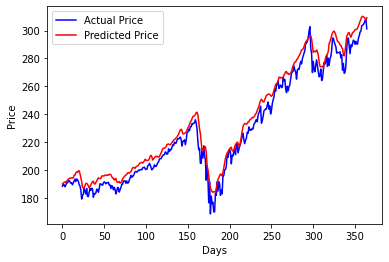

In [299]:
plot_graph(model, data, 365)

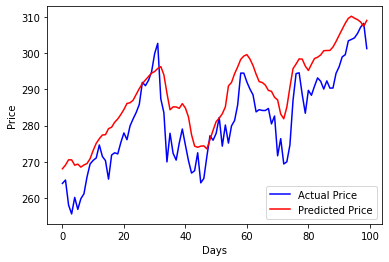

In [300]:
plot_graph(model, data, 100)

In [301]:
print(str(LOOKUP_STEP) + ":", "Accuracy Score:", get_accuracy(model, data))

1: Accuracy Score: 0.5637209302325581


(3.836297535443189, 2.6730144037635877)

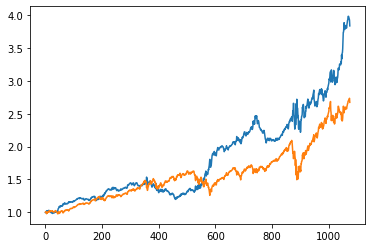

In [302]:
get_return(model, data)

## Model 2 Tesla price prediction

In [314]:
### Which stock to predict
ticker = "TSLA"

# use numbers of previous days to predict
N_STEPS = 100

# which day to predict, 1 is for next day, 10 is for 10 days after today
LOOKUP_STEP = 1

### model parameters
N_LAYERS = 3
CELL = LSTM
UNITS = 256
DROPOUT = 0.5

### training parameters
LOSS = "huber_loss"
OPTIMIZER = "adam"
BATCH_SIZE = 100
EPOCHS = 200

### other parameters
TEST_SIZE = 0.2
FEATURE_COLUMNS = ["adjclose", "volume", "open", "high", "low"]
date_now = time.strftime("%Y-%m-%d")

### save data to csv locally
ticker_data_filename = os.path.join("data", f"{ticker}_{date_now}.csv")
model_name = f"{date_now}_{ticker}-{LOSS}-{OPTIMIZER}-{CELL.__name__}-seq-{N_STEPS}-step-{LOOKUP_STEP}-layers-{N_LAYERS}-units-{UNITS}"

In [315]:
# load the data
data = load_data(ticker, N_STEPS, lookup_step=LOOKUP_STEP, test_size=TEST_SIZE, feature_columns=FEATURE_COLUMNS)
# save the dataframe
data["df"].to_csv(ticker_data_filename)
# construct the model
model = create_model(N_STEPS, loss=LOSS, units=UNITS, cell=CELL, n_layers=N_LAYERS,
                    dropout=DROPOUT, optimizer=OPTIMIZER)
# some tensorflow callbacks
checkpointer = ModelCheckpoint(os.path.join("results", model_name + ".h5"), save_weights_only=True, save_best_only=True, verbose=1)
tensorboard = TensorBoard(log_dir=os.path.join("logs", model_name))
history = model.fit(data["X_train"], data["y_train"],
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(data["X_test"], data["y_test"]),
                    callbacks=[checkpointer, tensorboard],
                    verbose=1)
model.save(os.path.join("results", model_name) + ".h5")

Epoch 1/200
20/21 [===========================>..] - ETA: 0s - loss: 0.0017 - mean_absolute_error: 0.0353
Epoch 00001: val_loss improved from inf to 0.00067, saving model to results/2020-12-10_TSLA-huber_loss-adam-LSTM-seq-100-step-1-layers-3-units-256.h5
21/21 [==============================] - 2s 110ms/step - loss: 0.0017 - mean_absolute_error: 0.0352 - val_loss: 6.6571e-04 - val_mean_absolute_error: 0.0218
Epoch 2/200
19/21 [==========================>...] - ETA: 0s - loss: 9.8943e-04 - mean_absolute_error: 0.0259
Epoch 00002: val_loss did not improve from 0.00067
21/21 [==============================] - 1s 30ms/step - loss: 0.0011 - mean_absolute_error: 0.0263 - val_loss: 7.5426e-04 - val_mean_absolute_error: 0.0195
Epoch 3/200
19/21 [==========================>...] - ETA: 0s - loss: 7.5096e-04 - mean_absolute_error: 0.0215
Epoch 00003: val_loss did not improve from 0.00067
21/21 [==============================] - 1s 31ms/step - loss: 7.4273e-04 - mean_absolute_error: 0.0216 - val_

Epoch 25/200
20/21 [===========================>..] - ETA: 0s - loss: 4.2694e-04 - mean_absolute_error: 0.0178
Epoch 00025: val_loss did not improve from 0.00030
21/21 [==============================] - 1s 30ms/step - loss: 4.2422e-04 - mean_absolute_error: 0.0177 - val_loss: 4.8171e-04 - val_mean_absolute_error: 0.0168
Epoch 26/200
19/21 [==========================>...] - ETA: 0s - loss: 3.1246e-04 - mean_absolute_error: 0.0148
Epoch 00026: val_loss improved from 0.00030 to 0.00027, saving model to results/2020-12-10_TSLA-huber_loss-adam-LSTM-seq-100-step-1-layers-3-units-256.h5
21/21 [==============================] - 1s 26ms/step - loss: 3.1149e-04 - mean_absolute_error: 0.0146 - val_loss: 2.6987e-04 - val_mean_absolute_error: 0.0102
Epoch 27/200
21/21 [==============================] - ETA: 0s - loss: 2.7619e-04 - mean_absolute_error: 0.0125
Epoch 00027: val_loss did not improve from 0.00027
21/21 [==============================] - 1s 26ms/step - loss: 2.7619e-04 - mean_absolute_er

21/21 [==============================] - ETA: 0s - loss: 2.7283e-04 - mean_absolute_error: 0.0139
Epoch 00049: val_loss did not improve from 0.00019
21/21 [==============================] - 1s 32ms/step - loss: 2.7283e-04 - mean_absolute_error: 0.0139 - val_loss: 3.8053e-04 - val_mean_absolute_error: 0.0165
Epoch 50/200
20/21 [===========================>..] - ETA: 0s - loss: 2.4954e-04 - mean_absolute_error: 0.0119
Epoch 00050: val_loss did not improve from 0.00019
21/21 [==============================] - 1s 29ms/step - loss: 2.4778e-04 - mean_absolute_error: 0.0119 - val_loss: 2.5899e-04 - val_mean_absolute_error: 0.0090
Epoch 51/200
20/21 [===========================>..] - ETA: 0s - loss: 1.9346e-04 - mean_absolute_error: 0.0100
Epoch 00051: val_loss did not improve from 0.00019
21/21 [==============================] - 1s 26ms/step - loss: 1.9150e-04 - mean_absolute_error: 0.0100 - val_loss: 2.1627e-04 - val_mean_absolute_error: 0.0089
Epoch 52/200
19/21 [==========================>

Epoch 74/200
19/21 [==========================>...] - ETA: 0s - loss: 1.4979e-04 - mean_absolute_error: 0.0092
Epoch 00074: val_loss did not improve from 0.00015
21/21 [==============================] - 1s 26ms/step - loss: 1.5342e-04 - mean_absolute_error: 0.0092 - val_loss: 1.9037e-04 - val_mean_absolute_error: 0.0083
Epoch 75/200
19/21 [==========================>...] - ETA: 0s - loss: 1.5373e-04 - mean_absolute_error: 0.0094
Epoch 00075: val_loss did not improve from 0.00015
21/21 [==============================] - 1s 26ms/step - loss: 1.5361e-04 - mean_absolute_error: 0.0095 - val_loss: 1.7017e-04 - val_mean_absolute_error: 0.0098
Epoch 76/200
20/21 [===========================>..] - ETA: 0s - loss: 1.9228e-04 - mean_absolute_error: 0.0114
Epoch 00076: val_loss did not improve from 0.00015
21/21 [==============================] - 1s 26ms/step - loss: 1.9418e-04 - mean_absolute_error: 0.0114 - val_loss: 2.1280e-04 - val_mean_absolute_error: 0.0071
Epoch 77/200
20/21 [==============

Epoch 99/200
19/21 [==========================>...] - ETA: 0s - loss: 2.0902e-04 - mean_absolute_error: 0.0114
Epoch 00099: val_loss did not improve from 0.00012
21/21 [==============================] - 1s 27ms/step - loss: 2.1389e-04 - mean_absolute_error: 0.0116 - val_loss: 1.7629e-04 - val_mean_absolute_error: 0.0090
Epoch 100/200
20/21 [===========================>..] - ETA: 0s - loss: 1.7122e-04 - mean_absolute_error: 0.0098
Epoch 00100: val_loss did not improve from 0.00012
21/21 [==============================] - 1s 27ms/step - loss: 1.6966e-04 - mean_absolute_error: 0.0097 - val_loss: 1.3203e-04 - val_mean_absolute_error: 0.0091
Epoch 101/200
19/21 [==========================>...] - ETA: 0s - loss: 1.4254e-04 - mean_absolute_error: 0.0094
Epoch 00101: val_loss did not improve from 0.00012
21/21 [==============================] - 1s 27ms/step - loss: 1.3820e-04 - mean_absolute_error: 0.0093 - val_loss: 1.6937e-04 - val_mean_absolute_error: 0.0068
Epoch 102/200
19/21 [===========

Epoch 124/200
19/21 [==========================>...] - ETA: 0s - loss: 1.4828e-04 - mean_absolute_error: 0.0099
Epoch 00124: val_loss did not improve from 0.00009
21/21 [==============================] - 1s 29ms/step - loss: 1.4333e-04 - mean_absolute_error: 0.0098 - val_loss: 1.0507e-04 - val_mean_absolute_error: 0.0066
Epoch 125/200
19/21 [==========================>...] - ETA: 0s - loss: 1.5416e-04 - mean_absolute_error: 0.0090
Epoch 00125: val_loss did not improve from 0.00009
21/21 [==============================] - 1s 30ms/step - loss: 1.5220e-04 - mean_absolute_error: 0.0091 - val_loss: 1.4108e-04 - val_mean_absolute_error: 0.0084
Epoch 126/200
20/21 [===========================>..] - ETA: 0s - loss: 1.5376e-04 - mean_absolute_error: 0.0095
Epoch 00126: val_loss did not improve from 0.00009
21/21 [==============================] - 1s 27ms/step - loss: 1.5296e-04 - mean_absolute_error: 0.0094 - val_loss: 1.2287e-04 - val_mean_absolute_error: 0.0069
Epoch 127/200
20/21 [==========

Epoch 149/200
20/21 [===========================>..] - ETA: 0s - loss: 1.3765e-04 - mean_absolute_error: 0.0082
Epoch 00149: val_loss did not improve from 0.00006
21/21 [==============================] - 1s 31ms/step - loss: 1.3661e-04 - mean_absolute_error: 0.0082 - val_loss: 7.9235e-05 - val_mean_absolute_error: 0.0054
Epoch 150/200
19/21 [==========================>...] - ETA: 0s - loss: 1.0418e-04 - mean_absolute_error: 0.0077
Epoch 00150: val_loss did not improve from 0.00006
21/21 [==============================] - 1s 34ms/step - loss: 1.0152e-04 - mean_absolute_error: 0.0077 - val_loss: 1.1139e-04 - val_mean_absolute_error: 0.0070
Epoch 151/200
19/21 [==========================>...] - ETA: 0s - loss: 1.5587e-04 - mean_absolute_error: 0.0094
Epoch 00151: val_loss did not improve from 0.00006
21/21 [==============================] - 1s 29ms/step - loss: 1.5773e-04 - mean_absolute_error: 0.0095 - val_loss: 1.1552e-04 - val_mean_absolute_error: 0.0077
Epoch 152/200
21/21 [==========

19/21 [==========================>...] - ETA: 0s - loss: 1.1275e-04 - mean_absolute_error: 0.0084
Epoch 00174: val_loss did not improve from 0.00006
21/21 [==============================] - 1s 30ms/step - loss: 1.1665e-04 - mean_absolute_error: 0.0085 - val_loss: 1.0153e-04 - val_mean_absolute_error: 0.0053
Epoch 175/200
20/21 [===========================>..] - ETA: 0s - loss: 1.0335e-04 - mean_absolute_error: 0.0080
Epoch 00175: val_loss did not improve from 0.00006
21/21 [==============================] - 1s 29ms/step - loss: 1.0257e-04 - mean_absolute_error: 0.0080 - val_loss: 1.2869e-04 - val_mean_absolute_error: 0.0072
Epoch 176/200
20/21 [===========================>..] - ETA: 0s - loss: 1.0382e-04 - mean_absolute_error: 0.0084
Epoch 00176: val_loss did not improve from 0.00006
21/21 [==============================] - 1s 29ms/step - loss: 1.0282e-04 - mean_absolute_error: 0.0084 - val_loss: 6.7785e-05 - val_mean_absolute_error: 0.0055
Epoch 177/200
19/21 [========================

19/21 [==========================>...] - ETA: 0s - loss: 1.0280e-04 - mean_absolute_error: 0.0082
Epoch 00199: val_loss did not improve from 0.00005
21/21 [==============================] - 1s 29ms/step - loss: 1.0700e-04 - mean_absolute_error: 0.0082 - val_loss: 2.0323e-04 - val_mean_absolute_error: 0.0063
Epoch 200/200
21/21 [==============================] - ETA: 0s - loss: 1.2193e-04 - mean_absolute_error: 0.0079
Epoch 00200: val_loss did not improve from 0.00005
21/21 [==============================] - 1s 29ms/step - loss: 1.2193e-04 - mean_absolute_error: 0.0079 - val_loss: 9.1286e-05 - val_mean_absolute_error: 0.0066


In [316]:
data = load_data(ticker, N_STEPS, lookup_step=LOOKUP_STEP, test_size=TEST_SIZE,
                feature_columns=FEATURE_COLUMNS, shuffle=False)

In [317]:
# predict the future price
future_price = predict(model, data)
print(f"Future price after {LOOKUP_STEP} days is {future_price:.2f}$")

Future price after 1 days is 566.68$


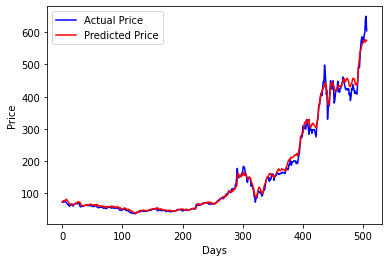

In [318]:
plot_graph(model, data, 1000)

In [319]:
print(str(LOOKUP_STEP) + ":", "Accuracy Score:", get_accuracy(model, data))

1: Accuracy Score: 0.5474308300395256


(10.995669922302485, 8.324794586756878)

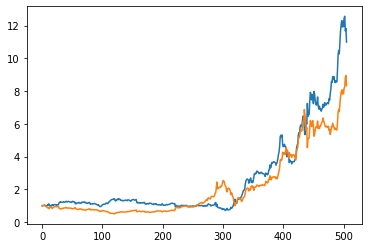

In [320]:
get_return(model, data)

## Model 3 S&P 500 price prediction

In [321]:
### Which stock to predict
ticker = "SPY"

# use numbers of previous days to predict
N_STEPS = 100

# which day to predict, 1 is for next day, 10 is for 10 days after today
LOOKUP_STEP = 1

### model parameters
N_LAYERS = 3
CELL = LSTM
UNITS = 256
DROPOUT = 0.5

### training parameters
LOSS = "huber_loss"
OPTIMIZER = "adam"
BATCH_SIZE = 100
EPOCHS = 200

### other parameters
TEST_SIZE = 0.2
FEATURE_COLUMNS = ["adjclose", "volume", "open", "high", "low"]
date_now = time.strftime("%Y-%m-%d")

### save data to csv locally
ticker_data_filename = os.path.join("data", f"{ticker}_{date_now}.csv")
model_name = f"{date_now}_{ticker}-{LOSS}-{OPTIMIZER}-{CELL.__name__}-seq-{N_STEPS}-step-{LOOKUP_STEP}-layers-{N_LAYERS}-units-{UNITS}"

In [322]:
# load the data
data = load_data(ticker, N_STEPS, lookup_step=LOOKUP_STEP, test_size=TEST_SIZE, feature_columns=FEATURE_COLUMNS)
# save the dataframe
data["df"].to_csv(ticker_data_filename)
# construct the model
model = create_model(N_STEPS, loss=LOSS, units=UNITS, cell=CELL, n_layers=N_LAYERS,
                    dropout=DROPOUT, optimizer=OPTIMIZER)
# some tensorflow callbacks
checkpointer = ModelCheckpoint(os.path.join("results", model_name + ".h5"), save_weights_only=True, save_best_only=True, verbose=1)
tensorboard = TensorBoard(log_dir=os.path.join("logs", model_name))
history = model.fit(data["X_train"], data["y_train"],
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(data["X_test"], data["y_test"]),
                    callbacks=[checkpointer, tensorboard],
                    verbose=1)
model.save(os.path.join("results", model_name) + ".h5")

Epoch 1/200
54/56 [===========================>..] - ETA: 0s - loss: 0.0051 - mean_absolute_error: 0.0617
Epoch 00001: val_loss improved from inf to 0.00042, saving model to results/2020-12-10_SPY-huber_loss-adam-LSTM-seq-100-step-1-layers-3-units-256.h5
56/56 [==============================] - 3s 49ms/step - loss: 0.0050 - mean_absolute_error: 0.0610 - val_loss: 4.2054e-04 - val_mean_absolute_error: 0.0189
Epoch 2/200
56/56 [==============================] - ETA: 0s - loss: 0.0013 - mean_absolute_error: 0.0330
Epoch 00002: val_loss improved from 0.00042 to 0.00033, saving model to results/2020-12-10_SPY-huber_loss-adam-LSTM-seq-100-step-1-layers-3-units-256.h5
56/56 [==============================] - 2s 28ms/step - loss: 0.0013 - mean_absolute_error: 0.0330 - val_loss: 3.2922e-04 - val_mean_absolute_error: 0.0176
Epoch 3/200
55/56 [============================>.] - ETA: 0s - loss: 0.0012 - mean_absolute_error: 0.0326
Epoch 00003: val_loss did not improve from 0.00033
56/56 [==========

Epoch 23/200
56/56 [==============================] - ETA: 0s - loss: 4.6077e-04 - mean_absolute_error: 0.0199
Epoch 00023: val_loss did not improve from 0.00010
56/56 [==============================] - 2s 27ms/step - loss: 4.6077e-04 - mean_absolute_error: 0.0199 - val_loss: 2.5353e-04 - val_mean_absolute_error: 0.0165
Epoch 24/200
55/56 [============================>.] - ETA: 0s - loss: 4.6622e-04 - mean_absolute_error: 0.0202
Epoch 00024: val_loss did not improve from 0.00010
56/56 [==============================] - 2s 28ms/step - loss: 4.6445e-04 - mean_absolute_error: 0.0202 - val_loss: 1.3277e-04 - val_mean_absolute_error: 0.0122
Epoch 25/200
54/56 [===========================>..] - ETA: 0s - loss: 5.1601e-04 - mean_absolute_error: 0.0214
Epoch 00025: val_loss improved from 0.00010 to 0.00009, saving model to results/2020-12-10_SPY-huber_loss-adam-LSTM-seq-100-step-1-layers-3-units-256.h5
56/56 [==============================] - 1s 26ms/step - loss: 5.1143e-04 - mean_absolute_err

54/56 [===========================>..] - ETA: 0s - loss: 3.3227e-04 - mean_absolute_error: 0.0170
Epoch 00047: val_loss did not improve from 0.00007
56/56 [==============================] - 2s 27ms/step - loss: 3.2854e-04 - mean_absolute_error: 0.0169 - val_loss: 1.2297e-04 - val_mean_absolute_error: 0.0125
Epoch 48/200
55/56 [============================>.] - ETA: 0s - loss: 3.1245e-04 - mean_absolute_error: 0.0166
Epoch 00048: val_loss did not improve from 0.00007
56/56 [==============================] - 2s 29ms/step - loss: 3.1323e-04 - mean_absolute_error: 0.0166 - val_loss: 1.3084e-04 - val_mean_absolute_error: 0.0130
Epoch 49/200
54/56 [===========================>..] - ETA: 0s - loss: 3.2269e-04 - mean_absolute_error: 0.0169
Epoch 00049: val_loss did not improve from 0.00007
56/56 [==============================] - 2s 30ms/step - loss: 3.2206e-04 - mean_absolute_error: 0.0169 - val_loss: 1.2810e-04 - val_mean_absolute_error: 0.0120
Epoch 50/200
56/56 [===========================

55/56 [============================>.] - ETA: 0s - loss: 2.5733e-04 - mean_absolute_error: 0.0153
Epoch 00071: val_loss did not improve from 0.00005
56/56 [==============================] - 2s 33ms/step - loss: 2.5775e-04 - mean_absolute_error: 0.0153 - val_loss: 6.0557e-05 - val_mean_absolute_error: 0.0086
Epoch 72/200
55/56 [============================>.] - ETA: 0s - loss: 2.4716e-04 - mean_absolute_error: 0.0149
Epoch 00072: val_loss did not improve from 0.00005
56/56 [==============================] - 2s 30ms/step - loss: 2.4606e-04 - mean_absolute_error: 0.0148 - val_loss: 9.1687e-05 - val_mean_absolute_error: 0.0105
Epoch 73/200
54/56 [===========================>..] - ETA: 0s - loss: 2.5362e-04 - mean_absolute_error: 0.0148
Epoch 00073: val_loss improved from 0.00005 to 0.00005, saving model to results/2020-12-10_SPY-huber_loss-adam-LSTM-seq-100-step-1-layers-3-units-256.h5
56/56 [==============================] - 2s 31ms/step - loss: 2.5103e-04 - mean_absolute_error: 0.0148 - 

56/56 [==============================] - 2s 30ms/step - loss: 2.5066e-04 - mean_absolute_error: 0.0153 - val_loss: 3.7936e-05 - val_mean_absolute_error: 0.0058
Epoch 96/200
54/56 [===========================>..] - ETA: 0s - loss: 2.2242e-04 - mean_absolute_error: 0.0140
Epoch 00096: val_loss did not improve from 0.00004
56/56 [==============================] - 2s 30ms/step - loss: 2.2126e-04 - mean_absolute_error: 0.0140 - val_loss: 5.6579e-05 - val_mean_absolute_error: 0.0071
Epoch 97/200
55/56 [============================>.] - ETA: 0s - loss: 2.3773e-04 - mean_absolute_error: 0.0148
Epoch 00097: val_loss did not improve from 0.00004
56/56 [==============================] - 2s 30ms/step - loss: 2.3731e-04 - mean_absolute_error: 0.0147 - val_loss: 4.9523e-05 - val_mean_absolute_error: 0.0071
Epoch 98/200
55/56 [============================>.] - ETA: 0s - loss: 2.0839e-04 - mean_absolute_error: 0.0137
Epoch 00098: val_loss did not improve from 0.00004
56/56 [===========================

Epoch 121/200
55/56 [============================>.] - ETA: 0s - loss: 2.2478e-04 - mean_absolute_error: 0.0144
Epoch 00121: val_loss did not improve from 0.00003
56/56 [==============================] - 2s 29ms/step - loss: 2.2487e-04 - mean_absolute_error: 0.0144 - val_loss: 2.7424e-04 - val_mean_absolute_error: 0.0186
Epoch 122/200
55/56 [============================>.] - ETA: 0s - loss: 2.6469e-04 - mean_absolute_error: 0.0163
Epoch 00122: val_loss did not improve from 0.00003
56/56 [==============================] - 2s 29ms/step - loss: 2.6411e-04 - mean_absolute_error: 0.0163 - val_loss: 9.9427e-05 - val_mean_absolute_error: 0.0093
Epoch 123/200
55/56 [============================>.] - ETA: 0s - loss: 2.4902e-04 - mean_absolute_error: 0.0149
Epoch 00123: val_loss did not improve from 0.00003
56/56 [==============================] - 2s 27ms/step - loss: 2.5251e-04 - mean_absolute_error: 0.0150 - val_loss: 1.3845e-04 - val_mean_absolute_error: 0.0133
Epoch 124/200
55/56 [==========

54/56 [===========================>..] - ETA: 0s - loss: 2.0469e-04 - mean_absolute_error: 0.0139
Epoch 00146: val_loss did not improve from 0.00003
56/56 [==============================] - 2s 30ms/step - loss: 2.0552e-04 - mean_absolute_error: 0.0140 - val_loss: 8.1790e-05 - val_mean_absolute_error: 0.0100
Epoch 147/200
55/56 [============================>.] - ETA: 0s - loss: 2.4451e-04 - mean_absolute_error: 0.0156
Epoch 00147: val_loss did not improve from 0.00003
56/56 [==============================] - 2s 28ms/step - loss: 2.4475e-04 - mean_absolute_error: 0.0156 - val_loss: 4.8940e-05 - val_mean_absolute_error: 0.0069
Epoch 148/200
55/56 [============================>.] - ETA: 0s - loss: 2.3331e-04 - mean_absolute_error: 0.0146
Epoch 00148: val_loss did not improve from 0.00003
56/56 [==============================] - 2s 28ms/step - loss: 2.3395e-04 - mean_absolute_error: 0.0147 - val_loss: 4.9058e-05 - val_mean_absolute_error: 0.0074
Epoch 149/200
55/56 [========================

Epoch 172/200
54/56 [===========================>..] - ETA: 0s - loss: 2.2790e-04 - mean_absolute_error: 0.0145
Epoch 00172: val_loss did not improve from 0.00003
56/56 [==============================] - 2s 31ms/step - loss: 2.2562e-04 - mean_absolute_error: 0.0145 - val_loss: 5.4055e-05 - val_mean_absolute_error: 0.0083
Epoch 173/200
55/56 [============================>.] - ETA: 0s - loss: 2.0354e-04 - mean_absolute_error: 0.0139
Epoch 00173: val_loss did not improve from 0.00003
56/56 [==============================] - 2s 31ms/step - loss: 2.0362e-04 - mean_absolute_error: 0.0139 - val_loss: 4.6619e-05 - val_mean_absolute_error: 0.0073
Epoch 174/200
55/56 [============================>.] - ETA: 0s - loss: 2.0934e-04 - mean_absolute_error: 0.0141
Epoch 00174: val_loss did not improve from 0.00003
56/56 [==============================] - 2s 29ms/step - loss: 2.0884e-04 - mean_absolute_error: 0.0141 - val_loss: 4.5896e-05 - val_mean_absolute_error: 0.0064
Epoch 175/200
55/56 [==========

Epoch 198/200
54/56 [===========================>..] - ETA: 0s - loss: 2.0903e-04 - mean_absolute_error: 0.0140
Epoch 00198: val_loss did not improve from 0.00003
56/56 [==============================] - 2s 29ms/step - loss: 2.0937e-04 - mean_absolute_error: 0.0140 - val_loss: 5.9360e-05 - val_mean_absolute_error: 0.0073
Epoch 199/200
56/56 [==============================] - ETA: 0s - loss: 2.0326e-04 - mean_absolute_error: 0.0140
Epoch 00199: val_loss did not improve from 0.00003
56/56 [==============================] - 2s 35ms/step - loss: 2.0326e-04 - mean_absolute_error: 0.0140 - val_loss: 4.4484e-05 - val_mean_absolute_error: 0.0060
Epoch 200/200
55/56 [============================>.] - ETA: 0s - loss: 2.2004e-04 - mean_absolute_error: 0.0142
Epoch 00200: val_loss did not improve from 0.00003
56/56 [==============================] - 2s 28ms/step - loss: 2.2008e-04 - mean_absolute_error: 0.0142 - val_loss: 3.1937e-05 - val_mean_absolute_error: 0.0053


In [323]:
data = load_data(ticker, N_STEPS, lookup_step=LOOKUP_STEP, test_size=TEST_SIZE,
                feature_columns=FEATURE_COLUMNS, shuffle=False)

In [324]:
# predict the future price
future_price = predict(model, data)
print(f"Future price after {LOOKUP_STEP} days is {future_price:.2f}$")

Future price after 1 days is 352.10$


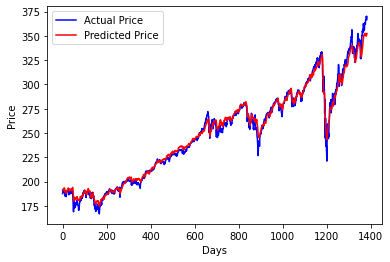

In [325]:
plot_graph(model, data, 1400)

In [326]:
print(str(LOOKUP_STEP) + ":", "Accuracy Score:", get_accuracy(model, data))

1: Accuracy Score: 0.5430224150397687


(1.6490368319261997, 1.9549996584710554)

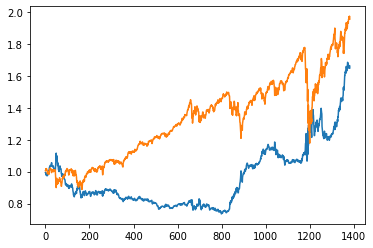

In [327]:
get_return(model, data)

### ExxonMobil

In [372]:
### Which stock to predict
ticker = "XOM"

# use numbers of previous days to predict
N_STEPS = 100

# which day to predict, 1 is for next day, 10 is for 10 days after today
LOOKUP_STEP = 1

### model parameters
N_LAYERS = 3
CELL = LSTM
UNITS = 256
DROPOUT = 0.5

### training parameters
LOSS = "huber_loss"
OPTIMIZER = "adam"
BATCH_SIZE = 100
EPOCHS = 100

### other parameters
TEST_SIZE = 0.2
FEATURE_COLUMNS = ["adjclose", "volume", "open", "high", "low"]
date_now = time.strftime("%Y-%m-%d")

### save data to csv locally
ticker_data_filename = os.path.join("data", f"{ticker}_{date_now}.csv")
model_name = f"{date_now}_{ticker}-{LOSS}-{OPTIMIZER}-{CELL.__name__}-seq-{N_STEPS}-step-{LOOKUP_STEP}-layers-{N_LAYERS}-units-{UNITS}"

In [373]:
# load the data
data = load_data(ticker, N_STEPS, lookup_step=LOOKUP_STEP, test_size=TEST_SIZE, feature_columns=FEATURE_COLUMNS)
# save the dataframe
data["df"].to_csv(ticker_data_filename)
# construct the model
model = create_model(N_STEPS, loss=LOSS, units=UNITS, cell=CELL, n_layers=N_LAYERS,
                    dropout=DROPOUT, optimizer=OPTIMIZER)
# some tensorflow callbacks
checkpointer = ModelCheckpoint(os.path.join("results", model_name + ".h5"), save_weights_only=True, save_best_only=True, verbose=1)
tensorboard = TensorBoard(log_dir=os.path.join("logs", model_name))
history = model.fit(data["X_train"], data["y_train"],
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(data["X_test"], data["y_test"]),
                    callbacks=[checkpointer, tensorboard],
                    verbose=1)
model.save(os.path.join("results", model_name) + ".h5")

Epoch 1/100
100/102 [============================>.] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0579
Epoch 00001: val_loss improved from inf to 0.00069, saving model to results/2020-12-10_XOM-huber_loss-adam-LSTM-seq-100-step-1-layers-3-units-256.h5
102/102 [==============================] - 4s 41ms/step - loss: 0.0056 - mean_absolute_error: 0.0575 - val_loss: 6.9226e-04 - val_mean_absolute_error: 0.0211
Epoch 2/100
101/102 [============================>.] - ETA: 0s - loss: 0.0016 - mean_absolute_error: 0.0324
Epoch 00002: val_loss improved from 0.00069 to 0.00049, saving model to results/2020-12-10_XOM-huber_loss-adam-LSTM-seq-100-step-1-layers-3-units-256.h5
102/102 [==============================] - 3s 31ms/step - loss: 0.0016 - mean_absolute_error: 0.0324 - val_loss: 4.8685e-04 - val_mean_absolute_error: 0.0171
Epoch 3/100
101/102 [============================>.] - ETA: 0s - loss: 0.0014 - mean_absolute_error: 0.0303
Epoch 00003: val_loss did not improve from 0.00049
102/102

Epoch 23/100
101/102 [============================>.] - ETA: 0s - loss: 5.9066e-04 - mean_absolute_error: 0.0221
Epoch 00023: val_loss did not improve from 0.00011
102/102 [==============================] - 3s 34ms/step - loss: 5.8931e-04 - mean_absolute_error: 0.0221 - val_loss: 1.3210e-04 - val_mean_absolute_error: 0.0112
Epoch 24/100
101/102 [============================>.] - ETA: 0s - loss: 5.4049e-04 - mean_absolute_error: 0.0214
Epoch 00024: val_loss did not improve from 0.00011
102/102 [==============================] - 3s 33ms/step - loss: 5.4272e-04 - mean_absolute_error: 0.0214 - val_loss: 1.1743e-04 - val_mean_absolute_error: 0.0115
Epoch 25/100
101/102 [============================>.] - ETA: 0s - loss: 5.3646e-04 - mean_absolute_error: 0.0212
Epoch 00025: val_loss did not improve from 0.00011
102/102 [==============================] - 3s 33ms/step - loss: 5.3513e-04 - mean_absolute_error: 0.0212 - val_loss: 1.1276e-04 - val_mean_absolute_error: 0.0086
Epoch 26/100
101/102 [

Epoch 47/100
101/102 [============================>.] - ETA: 0s - loss: 4.7565e-04 - mean_absolute_error: 0.0217
Epoch 00047: val_loss did not improve from 0.00008
102/102 [==============================] - 3s 33ms/step - loss: 4.7414e-04 - mean_absolute_error: 0.0217 - val_loss: 1.7865e-04 - val_mean_absolute_error: 0.0137
Epoch 48/100
101/102 [============================>.] - ETA: 0s - loss: 4.4834e-04 - mean_absolute_error: 0.0209
Epoch 00048: val_loss did not improve from 0.00008
102/102 [==============================] - 4s 36ms/step - loss: 4.4851e-04 - mean_absolute_error: 0.0209 - val_loss: 1.2913e-04 - val_mean_absolute_error: 0.0112
Epoch 49/100
101/102 [============================>.] - ETA: 0s - loss: 4.2996e-04 - mean_absolute_error: 0.0206
Epoch 00049: val_loss did not improve from 0.00008
102/102 [==============================] - 4s 35ms/step - loss: 4.3023e-04 - mean_absolute_error: 0.0206 - val_loss: 1.0131e-04 - val_mean_absolute_error: 0.0102
Epoch 50/100
101/102 [

101/102 [============================>.] - ETA: 0s - loss: 4.2496e-04 - mean_absolute_error: 0.0211
Epoch 00071: val_loss did not improve from 0.00005
102/102 [==============================] - 4s 36ms/step - loss: 4.2478e-04 - mean_absolute_error: 0.0211 - val_loss: 1.8169e-04 - val_mean_absolute_error: 0.0117
Epoch 72/100
101/102 [============================>.] - ETA: 0s - loss: 3.8744e-04 - mean_absolute_error: 0.0201
Epoch 00072: val_loss did not improve from 0.00005
102/102 [==============================] - 4s 35ms/step - loss: 3.8770e-04 - mean_absolute_error: 0.0201 - val_loss: 1.4808e-04 - val_mean_absolute_error: 0.0120
Epoch 73/100
101/102 [============================>.] - ETA: 0s - loss: 4.0917e-04 - mean_absolute_error: 0.0204
Epoch 00073: val_loss did not improve from 0.00005
102/102 [==============================] - 4s 38ms/step - loss: 4.1055e-04 - mean_absolute_error: 0.0205 - val_loss: 5.7835e-05 - val_mean_absolute_error: 0.0074
Epoch 74/100
101/102 [=============

102/102 [==============================] - ETA: 0s - loss: 3.8762e-04 - mean_absolute_error: 0.0202
Epoch 00095: val_loss did not improve from 0.00004
102/102 [==============================] - 4s 36ms/step - loss: 3.8762e-04 - mean_absolute_error: 0.0202 - val_loss: 1.3863e-04 - val_mean_absolute_error: 0.0136
Epoch 96/100
101/102 [============================>.] - ETA: 0s - loss: 3.7106e-04 - mean_absolute_error: 0.0200
Epoch 00096: val_loss did not improve from 0.00004
102/102 [==============================] - 3s 34ms/step - loss: 3.7082e-04 - mean_absolute_error: 0.0200 - val_loss: 2.1008e-04 - val_mean_absolute_error: 0.0170
Epoch 97/100
101/102 [============================>.] - ETA: 0s - loss: 4.2507e-04 - mean_absolute_error: 0.0210
Epoch 00097: val_loss did not improve from 0.00004
102/102 [==============================] - 4s 35ms/step - loss: 4.2444e-04 - mean_absolute_error: 0.0210 - val_loss: 5.0921e-05 - val_mean_absolute_error: 0.0066
Epoch 98/100
101/102 [=============

In [374]:
data = load_data(ticker, N_STEPS, lookup_step=LOOKUP_STEP, test_size=TEST_SIZE,
                feature_columns=FEATURE_COLUMNS, shuffle=False)

In [375]:
# predict the future price
future_price = predict(model, data)
print(f"Future price after {LOOKUP_STEP} days is {future_price:.2f}$")

Future price after 1 days is 40.04$


In [376]:
print(str(LOOKUP_STEP) + ":", "Accuracy Score:", get_accuracy(model, data))

1: Accuracy Score: 0.5200945626477541


(3.7783100075479825, 0.8987959190446589)

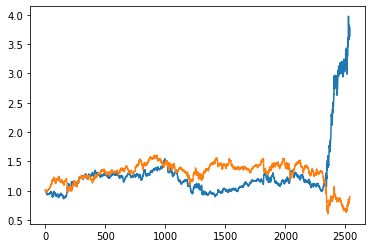

In [377]:
get_return(model, data)

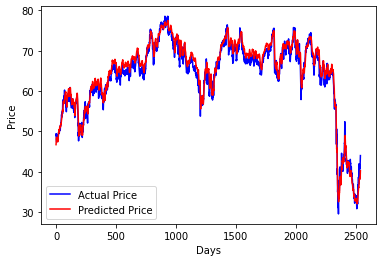

In [378]:
plot_graph(model, data, 2600)

### QQQ 300 - 30

In [379]:
### Which stock to predict
ticker = "QQQ"

# use numbers of previous days to predict
N_STEPS = 300

# which day to predict, 1 is for next day, 10 is for 10 days after today
LOOKUP_STEP = 30

### model parameters
N_LAYERS = 3
CELL = LSTM
UNITS = 256
DROPOUT = 0.5

### training parameters
LOSS = "huber_loss"
OPTIMIZER = "adam"
BATCH_SIZE = 50
EPOCHS = 200

### other parameters
TEST_SIZE = 0.2
FEATURE_COLUMNS = ["adjclose", "volume", "open", "high", "low"]
date_now = time.strftime("%Y-%m-%d")

### save data to csv locally
ticker_data_filename = os.path.join("data", f"{ticker}_{date_now}.csv")
model_name = f"{date_now}_{ticker}-{LOSS}-{OPTIMIZER}-{CELL.__name__}-seq-{N_STEPS}-step-{LOOKUP_STEP}-layers-{N_LAYERS}-units-{UNITS}"

In [380]:
# load the data
data = load_data(ticker, N_STEPS, lookup_step=LOOKUP_STEP, test_size=TEST_SIZE, feature_columns=FEATURE_COLUMNS)
data["df"].to_csv(ticker_data_filename)

# construct the model
model = create_model(N_STEPS, loss=LOSS, units=UNITS, cell=CELL, n_layers=N_LAYERS,
                    dropout=DROPOUT, optimizer=OPTIMIZER)

# some tensorflow callbacks
checkpointer = ModelCheckpoint(os.path.join("results", model_name + ".h5"), save_weights_only=True, save_best_only=True, verbose=1)
tensorboard = TensorBoard(log_dir=os.path.join("logs", model_name))
history = model.fit(data["X_train"], data["y_train"],
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(data["X_test"], data["y_test"]),
                    callbacks=[checkpointer, tensorboard],
                    verbose=1)
model.save(os.path.join("results", model_name) + ".h5")

Epoch 1/200
83/83 [==============================] - ETA: 0s - loss: 0.0036 - mean_absolute_error: 0.0555
Epoch 00001: val_loss improved from inf to 0.00155, saving model to results/2020-12-10_QQQ-huber_loss-adam-LSTM-seq-300-step-30-layers-3-units-256.h5
83/83 [==============================] - 3s 40ms/step - loss: 0.0036 - mean_absolute_error: 0.0555 - val_loss: 0.0016 - val_mean_absolute_error: 0.0417
Epoch 2/200
82/83 [============================>.] - ETA: 0s - loss: 0.0020 - mean_absolute_error: 0.0426
Epoch 00002: val_loss improved from 0.00155 to 0.00084, saving model to results/2020-12-10_QQQ-huber_loss-adam-LSTM-seq-300-step-30-layers-3-units-256.h5
83/83 [==============================] - 2s 26ms/step - loss: 0.0020 - mean_absolute_error: 0.0425 - val_loss: 8.4342e-04 - val_mean_absolute_error: 0.0283
Epoch 3/200
81/83 [============================>.] - ETA: 0s - loss: 0.0017 - mean_absolute_error: 0.0384
Epoch 00003: val_loss did not improve from 0.00084
83/83 [============

82/83 [============================>.] - ETA: 0s - loss: 5.6660e-04 - mean_absolute_error: 0.0217
Epoch 00023: val_loss did not improve from 0.00027
83/83 [==============================] - 2s 27ms/step - loss: 5.6621e-04 - mean_absolute_error: 0.0217 - val_loss: 2.8715e-04 - val_mean_absolute_error: 0.0141
Epoch 24/200
81/83 [============================>.] - ETA: 0s - loss: 5.7607e-04 - mean_absolute_error: 0.0225
Epoch 00024: val_loss did not improve from 0.00027
83/83 [==============================] - 2s 26ms/step - loss: 5.7645e-04 - mean_absolute_error: 0.0225 - val_loss: 5.2346e-04 - val_mean_absolute_error: 0.0180
Epoch 25/200
81/83 [============================>.] - ETA: 0s - loss: 6.5462e-04 - mean_absolute_error: 0.0234
Epoch 00025: val_loss did not improve from 0.00027
83/83 [==============================] - 2s 26ms/step - loss: 6.5504e-04 - mean_absolute_error: 0.0234 - val_loss: 4.5890e-04 - val_mean_absolute_error: 0.0196
Epoch 26/200
82/83 [===========================

82/83 [============================>.] - ETA: 0s - loss: 4.5841e-04 - mean_absolute_error: 0.0202
Epoch 00047: val_loss did not improve from 0.00019
83/83 [==============================] - 2s 29ms/step - loss: 4.5811e-04 - mean_absolute_error: 0.0202 - val_loss: 2.0664e-04 - val_mean_absolute_error: 0.0145
Epoch 48/200
83/83 [==============================] - ETA: 0s - loss: 4.3007e-04 - mean_absolute_error: 0.0193
Epoch 00048: val_loss did not improve from 0.00019
83/83 [==============================] - 2s 28ms/step - loss: 4.3007e-04 - mean_absolute_error: 0.0193 - val_loss: 2.1347e-04 - val_mean_absolute_error: 0.0144
Epoch 49/200
82/83 [============================>.] - ETA: 0s - loss: 4.4422e-04 - mean_absolute_error: 0.0200
Epoch 00049: val_loss did not improve from 0.00019
83/83 [==============================] - 2s 29ms/step - loss: 4.4421e-04 - mean_absolute_error: 0.0200 - val_loss: 1.9598e-04 - val_mean_absolute_error: 0.0121
Epoch 50/200
82/83 [===========================

Epoch 71/200
81/83 [============================>.] - ETA: 0s - loss: 3.7040e-04 - mean_absolute_error: 0.0183
Epoch 00071: val_loss did not improve from 0.00011
83/83 [==============================] - 2s 26ms/step - loss: 3.7128e-04 - mean_absolute_error: 0.0183 - val_loss: 1.3743e-04 - val_mean_absolute_error: 0.0113
Epoch 72/200
81/83 [============================>.] - ETA: 0s - loss: 3.5864e-04 - mean_absolute_error: 0.0185
Epoch 00072: val_loss did not improve from 0.00011
83/83 [==============================] - 2s 28ms/step - loss: 3.5830e-04 - mean_absolute_error: 0.0185 - val_loss: 1.4334e-04 - val_mean_absolute_error: 0.0108
Epoch 73/200
81/83 [============================>.] - ETA: 0s - loss: 3.1555e-04 - mean_absolute_error: 0.0174
Epoch 00073: val_loss improved from 0.00011 to 0.00011, saving model to results/2020-12-10_QQQ-huber_loss-adam-LSTM-seq-300-step-30-layers-3-units-256.h5
83/83 [==============================] - 2s 29ms/step - loss: 3.1508e-04 - mean_absolute_er

82/83 [============================>.] - ETA: 0s - loss: 3.2670e-04 - mean_absolute_error: 0.0176
Epoch 00095: val_loss did not improve from 0.00010
83/83 [==============================] - 2s 26ms/step - loss: 3.2580e-04 - mean_absolute_error: 0.0176 - val_loss: 1.2723e-04 - val_mean_absolute_error: 0.0106
Epoch 96/200
82/83 [============================>.] - ETA: 0s - loss: 2.8629e-04 - mean_absolute_error: 0.0166
Epoch 00096: val_loss improved from 0.00010 to 0.00009, saving model to results/2020-12-10_QQQ-huber_loss-adam-LSTM-seq-300-step-30-layers-3-units-256.h5
83/83 [==============================] - 2s 27ms/step - loss: 2.8590e-04 - mean_absolute_error: 0.0166 - val_loss: 8.5119e-05 - val_mean_absolute_error: 0.0093
Epoch 97/200
81/83 [============================>.] - ETA: 0s - loss: 2.8723e-04 - mean_absolute_error: 0.0167
Epoch 00097: val_loss did not improve from 0.00009
83/83 [==============================] - 2s 27ms/step - loss: 2.8621e-04 - mean_absolute_error: 0.0167 -

82/83 [============================>.] - ETA: 0s - loss: 2.7625e-04 - mean_absolute_error: 0.0165
Epoch 00119: val_loss did not improve from 0.00007
83/83 [==============================] - 2s 27ms/step - loss: 2.7569e-04 - mean_absolute_error: 0.0165 - val_loss: 8.0788e-05 - val_mean_absolute_error: 0.0090
Epoch 120/200
82/83 [============================>.] - ETA: 0s - loss: 2.8349e-04 - mean_absolute_error: 0.0166
Epoch 00120: val_loss did not improve from 0.00007
83/83 [==============================] - 2s 27ms/step - loss: 2.8295e-04 - mean_absolute_error: 0.0166 - val_loss: 1.2223e-04 - val_mean_absolute_error: 0.0106
Epoch 121/200
82/83 [============================>.] - ETA: 0s - loss: 2.7367e-04 - mean_absolute_error: 0.0164
Epoch 00121: val_loss did not improve from 0.00007
83/83 [==============================] - 2s 27ms/step - loss: 2.7356e-04 - mean_absolute_error: 0.0164 - val_loss: 1.7554e-04 - val_mean_absolute_error: 0.0123
Epoch 122/200
81/83 [========================

82/83 [============================>.] - ETA: 0s - loss: 2.3378e-04 - mean_absolute_error: 0.0152
Epoch 00144: val_loss did not improve from 0.00006
83/83 [==============================] - 2s 28ms/step - loss: 2.3315e-04 - mean_absolute_error: 0.0152 - val_loss: 7.2133e-05 - val_mean_absolute_error: 0.0084
Epoch 145/200
81/83 [============================>.] - ETA: 0s - loss: 2.3527e-04 - mean_absolute_error: 0.0154
Epoch 00145: val_loss did not improve from 0.00006
83/83 [==============================] - 2s 28ms/step - loss: 2.3485e-04 - mean_absolute_error: 0.0154 - val_loss: 1.4802e-04 - val_mean_absolute_error: 0.0108
Epoch 146/200
81/83 [============================>.] - ETA: 0s - loss: 2.7828e-04 - mean_absolute_error: 0.0164
Epoch 00146: val_loss did not improve from 0.00006
83/83 [==============================] - 2s 29ms/step - loss: 2.7733e-04 - mean_absolute_error: 0.0164 - val_loss: 7.2416e-05 - val_mean_absolute_error: 0.0086
Epoch 147/200
82/83 [========================

Epoch 170/200
82/83 [============================>.] - ETA: 0s - loss: 2.4885e-04 - mean_absolute_error: 0.0154
Epoch 00170: val_loss did not improve from 0.00005
83/83 [==============================] - 2s 27ms/step - loss: 2.4876e-04 - mean_absolute_error: 0.0154 - val_loss: 6.7715e-05 - val_mean_absolute_error: 0.0077
Epoch 171/200
82/83 [============================>.] - ETA: 0s - loss: 2.2770e-04 - mean_absolute_error: 0.0146
Epoch 00171: val_loss did not improve from 0.00005
83/83 [==============================] - 2s 26ms/step - loss: 2.2744e-04 - mean_absolute_error: 0.0146 - val_loss: 9.0409e-05 - val_mean_absolute_error: 0.0098
Epoch 172/200
81/83 [============================>.] - ETA: 0s - loss: 2.3858e-04 - mean_absolute_error: 0.0151
Epoch 00172: val_loss did not improve from 0.00005
83/83 [==============================] - 2s 27ms/step - loss: 2.3950e-04 - mean_absolute_error: 0.0152 - val_loss: 7.4931e-05 - val_mean_absolute_error: 0.0096
Epoch 173/200
82/83 [==========

82/83 [============================>.] - ETA: 0s - loss: 2.3902e-04 - mean_absolute_error: 0.0153
Epoch 00195: val_loss did not improve from 0.00004
83/83 [==============================] - 2s 27ms/step - loss: 2.3870e-04 - mean_absolute_error: 0.0153 - val_loss: 5.1224e-05 - val_mean_absolute_error: 0.0069
Epoch 196/200
82/83 [============================>.] - ETA: 0s - loss: 2.5798e-04 - mean_absolute_error: 0.0151
Epoch 00196: val_loss did not improve from 0.00004
83/83 [==============================] - 2s 27ms/step - loss: 2.5714e-04 - mean_absolute_error: 0.0151 - val_loss: 6.2653e-05 - val_mean_absolute_error: 0.0077
Epoch 197/200
81/83 [============================>.] - ETA: 0s - loss: 1.9157e-04 - mean_absolute_error: 0.0138
Epoch 00197: val_loss did not improve from 0.00004
83/83 [==============================] - 3s 32ms/step - loss: 1.9179e-04 - mean_absolute_error: 0.0138 - val_loss: 8.3171e-05 - val_mean_absolute_error: 0.0080
Epoch 198/200
82/83 [========================

In [381]:
data = load_data(ticker, N_STEPS, lookup_step=LOOKUP_STEP, test_size=TEST_SIZE,
                feature_columns=FEATURE_COLUMNS, shuffle=False)

In [382]:
# predict the future price
future_price = predict(model, data)
print(f"Future price after {LOOKUP_STEP} days is {future_price:.2f}$")

Future price after 30 days is 301.72$


In [383]:
print(str(LOOKUP_STEP) + ":", "Accuracy Score:", get_accuracy(model, data))

30: Accuracy Score: 0.834


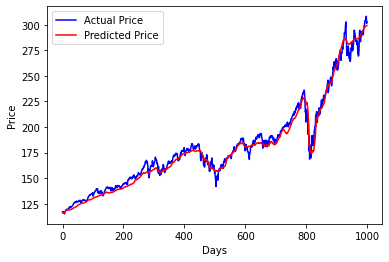

In [384]:
plot_graph(model, data)

In [396]:
def get_return(model, data):
    y_test = data["y_test"]
    X_test = data["X_test"]
    y_pred = model.predict(X_test)
    y_test = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(np.expand_dims(y_test, axis=0)))
    y_pred = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(y_pred))
    money = 1
    moneylist = []
    long_only = 1
    long_only_list = []
    for i in range(1,len(y_test)):
        if i % 30 == 0:
            if y_pred[i] >= y_pred[i-30]:
                long_short = 1
            else:
                long_short = -1
            money =  money * (1 + (y_test[i] - y_test[i-30])/y_test[i-30] * long_short) 
        long_only = long_only * (1 + (y_test[i] - y_test[i-1])/y_test[i-1] * 1) 
        moneylist.append(money)
        long_only_list.append(long_only)
    plt.plot(moneylist)
    plt.plot(long_only_list)
    return money,long_only

(4.994031142364982, 2.6685834680123746)

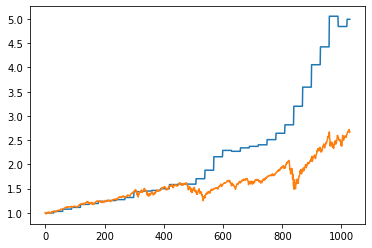

In [397]:
get_return(model, data)

### QQQ prediction using previous 500 day for next 100 days

In [399]:
### Which stock to predict
ticker = "QQQ"

# use numbers of previous days to predict
N_STEPS = 500

# which day to predict, 1 is for next day, 10 is for 10 days after today
LOOKUP_STEP = 100

### model parameters
N_LAYERS = 3
CELL = LSTM
UNITS = 256
DROPOUT = 0.5

### training parameters
LOSS = "huber_loss"
OPTIMIZER = "adam"
BATCH_SIZE = 50
EPOCHS = 200

### other parameters
TEST_SIZE = 0.2
FEATURE_COLUMNS = ["adjclose", "volume", "open", "high", "low"]
date_now = time.strftime("%Y-%m-%d")

### save data to csv locally
ticker_data_filename = os.path.join("data", f"{ticker}_{date_now}.csv")
model_name = f"{date_now}_{ticker}-{LOSS}-{OPTIMIZER}-{CELL.__name__}-seq-{N_STEPS}-step-{LOOKUP_STEP}-layers-{N_LAYERS}-units-{UNITS}"

In [400]:
# load the data
data = load_data(ticker, N_STEPS, lookup_step=LOOKUP_STEP, test_size=TEST_SIZE, feature_columns=FEATURE_COLUMNS)
data["df"].to_csv(ticker_data_filename)

# construct the model
model = create_model(N_STEPS, loss=LOSS, units=UNITS, cell=CELL, n_layers=N_LAYERS,
                    dropout=DROPOUT, optimizer=OPTIMIZER)

# some tensorflow callbacks
checkpointer = ModelCheckpoint(os.path.join("results", model_name + ".h5"), save_weights_only=True, save_best_only=True, verbose=1)
tensorboard = TensorBoard(log_dir=os.path.join("logs", model_name))
history = model.fit(data["X_train"], data["y_train"],
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(data["X_test"], data["y_test"]),
                    callbacks=[checkpointer, tensorboard],
                    verbose=1)
model.save(os.path.join("results", model_name) + ".h5")

Epoch 1/200
79/79 [==============================] - ETA: 0s - loss: 0.0042 - mean_absolute_error: 0.0611
Epoch 00001: val_loss improved from inf to 0.00149, saving model to results/2020-12-10_QQQ-huber_loss-adam-LSTM-seq-500-step-100-layers-3-units-256.h5
79/79 [==============================] - 5s 60ms/step - loss: 0.0042 - mean_absolute_error: 0.0611 - val_loss: 0.0015 - val_mean_absolute_error: 0.0377
Epoch 2/200
78/79 [============================>.] - ETA: 0s - loss: 0.0020 - mean_absolute_error: 0.0444
Epoch 00002: val_loss did not improve from 0.00149
79/79 [==============================] - 3s 36ms/step - loss: 0.0020 - mean_absolute_error: 0.0444 - val_loss: 0.0021 - val_mean_absolute_error: 0.0480
Epoch 3/200
79/79 [==============================] - ETA: 0s - loss: 0.0021 - mean_absolute_error: 0.0436
Epoch 00003: val_loss improved from 0.00149 to 0.00122, saving model to results/2020-12-10_QQQ-huber_loss-adam-LSTM-seq-500-step-100-layers-3-units-256.h5
79/79 [==============

79/79 [==============================] - ETA: 0s - loss: 8.3851e-04 - mean_absolute_error: 0.0269
Epoch 00023: val_loss did not improve from 0.00036
79/79 [==============================] - 3s 36ms/step - loss: 8.3851e-04 - mean_absolute_error: 0.0269 - val_loss: 3.8377e-04 - val_mean_absolute_error: 0.0191
Epoch 24/200
79/79 [==============================] - ETA: 0s - loss: 8.5992e-04 - mean_absolute_error: 0.0262
Epoch 00024: val_loss did not improve from 0.00036
79/79 [==============================] - 3s 36ms/step - loss: 8.5992e-04 - mean_absolute_error: 0.0262 - val_loss: 0.0031 - val_mean_absolute_error: 0.0505
Epoch 25/200
79/79 [==============================] - ETA: 0s - loss: 0.0017 - mean_absolute_error: 0.0376
Epoch 00025: val_loss did not improve from 0.00036
79/79 [==============================] - 3s 35ms/step - loss: 0.0017 - mean_absolute_error: 0.0376 - val_loss: 4.5872e-04 - val_mean_absolute_error: 0.0213
Epoch 26/200
79/79 [==============================] - ETA: 

Epoch 47/200
78/79 [============================>.] - ETA: 0s - loss: 4.4307e-04 - mean_absolute_error: 0.0201
Epoch 00047: val_loss did not improve from 0.00012
79/79 [==============================] - 3s 36ms/step - loss: 4.4323e-04 - mean_absolute_error: 0.0202 - val_loss: 1.3739e-04 - val_mean_absolute_error: 0.0128
Epoch 48/200
78/79 [============================>.] - ETA: 0s - loss: 4.8193e-04 - mean_absolute_error: 0.0211
Epoch 00048: val_loss did not improve from 0.00012
79/79 [==============================] - 3s 34ms/step - loss: 4.8171e-04 - mean_absolute_error: 0.0211 - val_loss: 1.5689e-04 - val_mean_absolute_error: 0.0126
Epoch 49/200
79/79 [==============================] - ETA: 0s - loss: 4.0245e-04 - mean_absolute_error: 0.0194
Epoch 00049: val_loss did not improve from 0.00012
79/79 [==============================] - 3s 38ms/step - loss: 4.0245e-04 - mean_absolute_error: 0.0194 - val_loss: 1.5276e-04 - val_mean_absolute_error: 0.0132
Epoch 50/200
79/79 [==============

Epoch 72/200
77/79 [============================>.] - ETA: 0s - loss: 4.4889e-04 - mean_absolute_error: 0.0199
Epoch 00072: val_loss did not improve from 0.00012
79/79 [==============================] - 2s 30ms/step - loss: 4.4884e-04 - mean_absolute_error: 0.0200 - val_loss: 1.2247e-04 - val_mean_absolute_error: 0.0121
Epoch 73/200
79/79 [==============================] - ETA: 0s - loss: 4.4237e-04 - mean_absolute_error: 0.0201
Epoch 00073: val_loss did not improve from 0.00012
79/79 [==============================] - 3s 33ms/step - loss: 4.4237e-04 - mean_absolute_error: 0.0201 - val_loss: 3.1632e-04 - val_mean_absolute_error: 0.0198
Epoch 74/200
77/79 [============================>.] - ETA: 0s - loss: 3.7123e-04 - mean_absolute_error: 0.0188
Epoch 00074: val_loss did not improve from 0.00012
79/79 [==============================] - 3s 32ms/step - loss: 3.7096e-04 - mean_absolute_error: 0.0187 - val_loss: 1.4521e-04 - val_mean_absolute_error: 0.0119
Epoch 75/200
78/79 [==============

Epoch 97/200
78/79 [============================>.] - ETA: 0s - loss: 3.1411e-04 - mean_absolute_error: 0.0166
Epoch 00097: val_loss did not improve from 0.00008
79/79 [==============================] - 2s 32ms/step - loss: 3.1412e-04 - mean_absolute_error: 0.0166 - val_loss: 1.1613e-04 - val_mean_absolute_error: 0.0115
Epoch 98/200
79/79 [==============================] - ETA: 0s - loss: 3.3759e-04 - mean_absolute_error: 0.0176
Epoch 00098: val_loss improved from 0.00008 to 0.00007, saving model to results/2020-12-10_QQQ-huber_loss-adam-LSTM-seq-500-step-100-layers-3-units-256.h5
79/79 [==============================] - 3s 35ms/step - loss: 3.3759e-04 - mean_absolute_error: 0.0176 - val_loss: 7.1844e-05 - val_mean_absolute_error: 0.0078
Epoch 99/200
78/79 [============================>.] - ETA: 0s - loss: 2.7628e-04 - mean_absolute_error: 0.0163
Epoch 00099: val_loss did not improve from 0.00007
79/79 [==============================] - 3s 34ms/step - loss: 2.7614e-04 - mean_absolute_e

Epoch 122/200
77/79 [============================>.] - ETA: 0s - loss: 2.4016e-04 - mean_absolute_error: 0.0153
Epoch 00122: val_loss did not improve from 0.00007
79/79 [==============================] - 3s 35ms/step - loss: 2.3945e-04 - mean_absolute_error: 0.0153 - val_loss: 7.9610e-05 - val_mean_absolute_error: 0.0091
Epoch 123/200
78/79 [============================>.] - ETA: 0s - loss: 2.4989e-04 - mean_absolute_error: 0.0151
Epoch 00123: val_loss did not improve from 0.00007
79/79 [==============================] - 3s 38ms/step - loss: 2.4985e-04 - mean_absolute_error: 0.0151 - val_loss: 8.5134e-05 - val_mean_absolute_error: 0.0099
Epoch 124/200
79/79 [==============================] - ETA: 0s - loss: 2.6679e-04 - mean_absolute_error: 0.0163
Epoch 00124: val_loss did not improve from 0.00007
79/79 [==============================] - 3s 34ms/step - loss: 2.6679e-04 - mean_absolute_error: 0.0163 - val_loss: 1.5877e-04 - val_mean_absolute_error: 0.0114
Epoch 125/200
78/79 [==========

Epoch 147/200
78/79 [============================>.] - ETA: 0s - loss: 2.5987e-04 - mean_absolute_error: 0.0158
Epoch 00147: val_loss did not improve from 0.00006
79/79 [==============================] - 3s 34ms/step - loss: 2.5979e-04 - mean_absolute_error: 0.0158 - val_loss: 7.5498e-05 - val_mean_absolute_error: 0.0082
Epoch 148/200
78/79 [============================>.] - ETA: 0s - loss: 2.2229e-04 - mean_absolute_error: 0.0144
Epoch 00148: val_loss did not improve from 0.00006
79/79 [==============================] - 3s 35ms/step - loss: 2.2247e-04 - mean_absolute_error: 0.0144 - val_loss: 1.0005e-04 - val_mean_absolute_error: 0.0106
Epoch 149/200
77/79 [============================>.] - ETA: 0s - loss: 2.8110e-04 - mean_absolute_error: 0.0167
Epoch 00149: val_loss did not improve from 0.00006
79/79 [==============================] - 3s 35ms/step - loss: 2.8121e-04 - mean_absolute_error: 0.0167 - val_loss: 9.1659e-05 - val_mean_absolute_error: 0.0103
Epoch 150/200
77/79 [==========

Epoch 172/200
79/79 [==============================] - ETA: 0s - loss: 2.0900e-04 - mean_absolute_error: 0.0138
Epoch 00172: val_loss did not improve from 0.00005
79/79 [==============================] - 3s 32ms/step - loss: 2.0900e-04 - mean_absolute_error: 0.0138 - val_loss: 5.8922e-04 - val_mean_absolute_error: 0.0232
Epoch 173/200
79/79 [==============================] - ETA: 0s - loss: 4.4540e-04 - mean_absolute_error: 0.0194
Epoch 00173: val_loss did not improve from 0.00005
79/79 [==============================] - 3s 34ms/step - loss: 4.4540e-04 - mean_absolute_error: 0.0194 - val_loss: 5.3297e-05 - val_mean_absolute_error: 0.0070
Epoch 174/200
77/79 [============================>.] - ETA: 0s - loss: 3.2872e-04 - mean_absolute_error: 0.0164
Epoch 00174: val_loss did not improve from 0.00005
79/79 [==============================] - 3s 34ms/step - loss: 3.2687e-04 - mean_absolute_error: 0.0164 - val_loss: 5.9174e-05 - val_mean_absolute_error: 0.0080
Epoch 175/200
78/79 [==========

Epoch 197/200
79/79 [==============================] - ETA: 0s - loss: 2.3466e-04 - mean_absolute_error: 0.0145
Epoch 00197: val_loss did not improve from 0.00004
79/79 [==============================] - 3s 33ms/step - loss: 2.3466e-04 - mean_absolute_error: 0.0145 - val_loss: 8.1015e-05 - val_mean_absolute_error: 0.0084
Epoch 198/200
78/79 [============================>.] - ETA: 0s - loss: 2.3925e-04 - mean_absolute_error: 0.0146
Epoch 00198: val_loss did not improve from 0.00004
79/79 [==============================] - 3s 33ms/step - loss: 2.3914e-04 - mean_absolute_error: 0.0146 - val_loss: 7.6122e-05 - val_mean_absolute_error: 0.0090
Epoch 199/200
79/79 [==============================] - ETA: 0s - loss: 2.3185e-04 - mean_absolute_error: 0.0144
Epoch 00199: val_loss did not improve from 0.00004
79/79 [==============================] - 3s 34ms/step - loss: 2.3185e-04 - mean_absolute_error: 0.0144 - val_loss: 4.8400e-05 - val_mean_absolute_error: 0.0068
Epoch 200/200
78/79 [==========

In [402]:
data = load_data(ticker, N_STEPS, lookup_step=LOOKUP_STEP, test_size=TEST_SIZE,
                feature_columns=FEATURE_COLUMNS, shuffle=False)

In [403]:
# predict the future price
future_price = predict(model, data)
print(f"Future price after {LOOKUP_STEP} days is {future_price:.2f}$")

Future price after 100 days is 287.05$


In [404]:
print(str(LOOKUP_STEP) + ":", "Accuracy Score:", get_accuracy(model, data))

100: Accuracy Score: 0.9863013698630136


In [411]:
def get_return(model, data):
    y_test = data["y_test"]
    X_test = data["X_test"]
    y_pred = model.predict(X_test)
    y_test = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(np.expand_dims(y_test, axis=0)))
    y_pred = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(y_pred))
    money = 1
    moneylist = []
    long_only = 1
    long_only_list = []
    for i in range(1,len(y_test)):
        if i % 100 == 0:
            if y_pred[i] >= y_pred[i-100]:
                long_short = 1
            else:
                long_short = -1
            money =  money * (1 + (y_test[i] - y_test[i-100])/y_test[i-100] * long_short) 
        long_only = long_only * (1 + (y_test[i] - y_test[i-1])/y_test[i-1] * 1) 
        moneylist.append(money)
        long_only_list.append(long_only)
    plt.plot(moneylist)
    plt.plot(long_only_list)
    return money,long_only

(3.4269236313316087, 2.476917979651391)

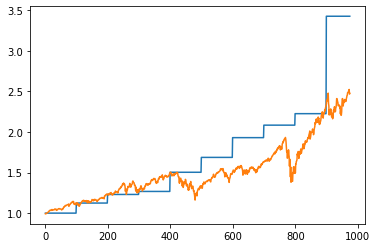

In [412]:
get_return(model, data)

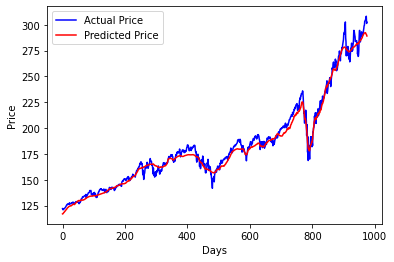

In [413]:
plot_graph(model, data)